# DeMarkify (baseline)

**TO DO**

*Top Priority*
- Figure out infrence image size scaling (see below section)

*Sould get done at some point*
- Save pre-gan cylce gen/crit models seperate from normal ones
- More markify functions for better generalization
- Figure out what "fn_factor" and "fn" means
- Try using a bigger resnet for better feature detection
- Play with image size/bs with single gpu training
- Look at training options on GCP
- Web App stuff
- Get markify functions to scale with image size
- Try splitting up higher-res images into smaller images and peice them back together for inference
- create "benchmark" folders of test images being passed through different models/checkpoints 
- Look at critic "most confused" images (if possible) to find and delete "bad" training images

*Would be nice to have*
- Refactor utility functions for cleanliness
- Look into Tensorboard callbacks
- "Scriptify" notebook for training everything in 1 command




In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai.vision import *
from fastai.vision.gan import *
from fastai.layers import *
import dill as pickle

from PIL import Image, ImageDraw, ImageFont, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import string, time

from save import *
from util import *
from markify import *

In [ ]:
torch.cuda.set_device(0)
print(f"Using GPU {torch.cuda.current_device()}")

## Data

#### ImageNet ILSVRC2011 Trianing Set

Roughly 1.2 million images from the training set of an ImageNet competition (http://www.image-net.org/challenges/LSVRC/2011/registered-downloads)

In [ ]:
# Make subset for testing
image_subset(100, CLEAN, CLEAN_SUB)

In [ ]:
open_image(CLEAN_SUB.ls()[0])

In [ ]:
markify(CLEAN_SUB, MARKED_SUB)

In [ ]:
len(CLEAN_SUB.ls()), len(MARKED_SUB.ls())

In [ ]:
open_image(MARKED_SUB.ls()[0])

### Markify Images

In [ ]:
# %%time
# markify(CLEAN, MARKED)

In [ ]:
len(os.listdir(MARKED)), len(os.listdir(CLEAN))

In [ ]:
open_image(MARKED_SUB.ls()[5])

In [ ]:
open_image(CLEAN.ls()[4])

## Modeling

### Pretrain Generator

#### 64px

In [ ]:
gc.collect()

In [ ]:
bs = 88
sz = 64
keep_pct = 1.0

In [ ]:
data_gen = get_data(bs, sz, keep_pct, CLEAN)

In [ ]:
data_gen.show_batch(10)

In [ ]:
wd = 1e-3
y_range = (-3.,3.)
loss_gen = MSELossFlat()
# loss_gen = FeatureLoss()

In [ ]:
%%time
learn_gen = create_gen_learner(path=PATH)

In [ ]:
learn_gen.fit_one_cycle(1, pct_start=0.8, max_lr=slice(1e-3))

In [ ]:
learn_gen.save(pre_gen_name)

In [ ]:
learn_gen.unfreeze()

In [ ]:
learn_gen.fit_one_cycle(1, pct_start=pct_start, max_lr=slice(3e-7, 3e-4))

In [ ]:
learn_gen.save(pre_gen_name)

#### 128px

In [ ]:
bs = 22
sz = 128
keep_pct = 1.0

In [ ]:
learn_gen.data = get_data(bs, sz, keep_pct, CLEAN)

In [ ]:
learn_gen.unfreeze()

In [ ]:
learn_gen.fit_one_cycle(1, pct_start=pct_start, max_lr=slice(1e-7,1e-4))

In [ ]:
learn_gen.save(pre_gen_name)

#### 192px

In [ ]:
bs = 11
sz = 192
keep_pct = 0.50

In [ ]:
learn_gen.data = get_data(bs, sz, keep_pct, CLEAN)

In [ ]:
learn_gen.unfreeze()

In [ ]:
learn_gen.fit_one_cycle(1, pct_start=pct_start, max_lr=slice(5e-8,5e-5))

In [ ]:
learn_gen.save(pre_gen_name)

### GAN Cycle

Make sure `old_checkpoint_num` is set to 0 when training a new set of models.

In [ ]:
old_checkpoint_num = 0
checkpoint_num = old_checkpoint_num + 1
gen_old_checkpoint_name = f"{gen_name}_{str(old_checkpoint_num)}"
gen_new_checkpoint_name = f"{gen_name}_{str(checkpoint_num)}"
crit_old_checkpoint_name = f"{crit_name}_{str(old_checkpoint_num)}"
crit_new_checkpoint_name = f"{crit_name}_{str(checkpoint_num)}"

#### Save Generated Images

In [ ]:
bs = 8
sz = 192

In [ ]:
gen_old_checkpoint_name

In [ ]:
learn_gen = create_gen_learner(path=PATH).load(gen_old_checkpoint_name)

In [ ]:
import pdb

In [ ]:
def save_preds(dl):
#     pdb.set_trace()
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(IMG_GEN/names[i].name)
            i += 1
    
def save_gen_images():
#     pdb.set_trace()
    if IMG_GEN.exists(): shutil.rmtree(IMG_GEN)
    IMG_GEN.mkdir(exist_ok=True)
    data_gen = get_data(bs,sz, 0.085, CLEAN)
    save_preds(data_gen.fix_dl)
    PIL.Image.open(IMG_GEN.ls()[0])

In [ ]:
%%time
save_gen_images()

#### Pretrain Critic

In [ ]:
IMG_GEN

In [ ]:
# c_img = open_image("data/marked/ILSVRC2011_val_00046504.png")
# c_img

In [ ]:
IMG_GEN.ls()[9]

In [ ]:
img = open_image(IMG_GEN.ls()[9])
img

In [ ]:
img.size

In [ ]:
c_img = open_image(MARKED.ls()[9])
c_img

In [ ]:
gc.collect()

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
# loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [ ]:
if old_checkpoint_num == 0:
    bs = 64
    sz = 128
    learn_gen = None
    gc.collect()
    data_crit = get_crit_data(["image_gen", "clean"], bs, sz, PATH)
    data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)
    loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())
    learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand, path=PATH)
    learn_critic.fit_one_cycle(6, 1e-3)
    learn_critic.save(crit_old_checkpoint_name)

In [ ]:
bs = 16
size = 192

In [ ]:
data_crit = get_crit_data(["image_gen", "clean"], bs, sz, PATH)

In [ ]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [ ]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand, PATH).load(crit_old_checkpoint_name)

In [ ]:
learn_critic.fit_one_cycle(4, 1e-4)

In [ ]:
learn_critic.save(crit_new_checkpoint_name)

#### GAN

In [ ]:
learn_crit=None
learn_gen=None
gc.collect()

In [ ]:
bs = 9
sz = 192
lr = 1e-5

In [ ]:
data_crit = get_crit_data(['marked', 'clean'], bs, size, PATH)

In [ ]:
learn_crit = create_critic_learner(data_crit, metrics=None, path=PATH).load(crit_new_checkpoint_name)

In [ ]:
learn_gen = create_gen_learner(path=PATH).load(gen_old_checkpoint_name)

In [ ]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd, path=PATH)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))
learn.callback_fns.append(partial(GANSaveCallback, learn_gen=learn_gen, filename=gen_new_checkpoint_name, save_iters=1))

In [ ]:
keep_pct = 0.03
learn.data = get_data(bs, sz, keep_pct, CLEAN)

In [ ]:
learn_gen.freeze_to(-1)

In [ ]:
learn.fit(1, lr)

In [ ]:
learn.show_results(rows=12)

Export Model

In [ ]:
learn_gen = create_gen_learner(path=PATH).load(gen_new_checkpoint_name)
# learn_gen = create_gen_learner(path=PATH).load("small_gen_1")

In [ ]:
learn_gen.export()

## Playground

### Testing Inference Learner

**10/19/2019**
- *Fastai* Needs to be version 1.0.55 and *Pytorch* version 1.1.0 (See [this thread](https://forums.fast.ai/t/fastai-pytorch-import-error/52201/2?u=waydegg) and [this thread](https://forums.fast.ai/t/pixelshuffle-icnr-object-has-no-attribute-do-blur-on-binary-segmentation-prediction/53950/2?u=waydegg)) for training and exporting to torchscript

In [1]:
import fastai
from fastai.vision import *
from inference import markify_learner
from pathlib import Path
from config import *
import matplotlib.pyplot as plt
import torch
from torchvision import models, transforms
import torchvision.transforms.functional as F

In [2]:
fastai.__version__, torch.__version__

('1.0.59', '1.3.0')

In [3]:
PATH = Path("data")
TEST = Path(PATH/'test_pics')
TEST.ls()

[PosixPath('data/test_pics/test2.jpg'),
 PosixPath('data/test_pics/pred_img_gen.png'),
 PosixPath('data/test_pics/waydegg@blacklab.ddns.net'),
 PosixPath('data/test_pics/test3.jpg'),
 PosixPath('data/test_pics/swirl.png'),
 PosixPath('data/test_pics/angery_rudy.jpg'),
 PosixPath('data/test_pics/0325.jpg'),
 PosixPath('data/test_pics/test1.jpg'),
 PosixPath('data/test_pics/wayde.jpg'),
 PosixPath('data/test_pics/dims.jpg'),
 PosixPath('data/test_pics/test5.jpg'),
 PosixPath('data/test_pics/0172.jpg'),
 PosixPath('data/test_pics/test4.jpg'),
 PosixPath('data/test_pics/0172 (1).jpg'),
 PosixPath('data/test_pics/old-age-tourism-travel-people-450w-1009880623.jpg'),
 PosixPath('data/test_pics/pred_img.png'),
 PosixPath('data/test_pics/pred_img_0.png'),
 PosixPath('data/test_pics/test6.jpg'),
 PosixPath('data/test_pics/gary.jpg')]

Load Torch Model

In [4]:
model_path = "data/models/larger_input.pkl"
model = torch.jit.load(model_path, map_location=torch.device('cpu')).eval()

In [5]:
# torch image preprocessing
preprocess = transforms.Compose([
    transforms.Resize((192,192)),
    transforms.ToTensor()
])

In [6]:
img_url = "https://i.ibb.co/yVLvm1R/b26d35d6ffe4.jpg"
img_request = requests.get(img_url, stream=True)
img = PIL.Image.open(io.BytesIO(img_request.content))
img_tensor = preprocess(img)
img_tensor = img_tensor.unsqueeze(0)
img_tensor.shape

torch.Size([1, 3, 192, 192])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


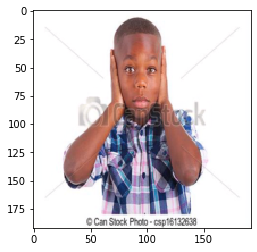

In [7]:
output_img = model(img_tensor).squeeze()
plt.imshow(output_img.permute(1,2,0))

Load Fastai Model (GPU)

In [8]:
learner = markify_learner("data/models", "larger_input.pkl")

RuntimeError: data/models/larger_input.pkl is a zip archive (did you mean to use torch.jit.load()?)

In [ ]:
# torch image preprocessing
preprocess = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

In [ ]:
img = open_image(TEST/"test3.jpg")
display(img.size, img)

In [ ]:
learner.generate_image(img)

### Exporting Model to AWS S3

To compile Unet models, you have to comment out the line in pytorch that raises a value error if your model has hooks. See [this thread](https://stackoverflow.com/a/56242858/3654891) for more details.

In [1]:
from inference import markify_learner
from config import *
import export
from database_util import *
from requests_html import HTMLSession

In [20]:
model_fn = "export.pkl"
# model_to_upload = markify_learner(MODELS, model_fn).model
model_to_upload = torch.jit.load(str(MODELS) + "/" + model_fn, map_location=torch.device('cpu')).eval()
model_trace_input = torch.ones(1,3,192,192).cpu()

In [21]:
# export.s3_upload(model_trace_input, model_to_upload, "serialized_baseline_02")
s3_transfer(MODEL_BUCKET, str(MODELS) + "/" + model_fn, "upload")

### SAM Local Inference Testing

Build the application (install packages from requirements.txt)

```sam build```

To run sam app locally:
    
```sam local invoke PyTorchFunction -n env.json -e events/event.json ```

### Exporting App to AWS SAM

0. If there isn't a s3 bucket already created, make an s3 bucket for the SAM app

```aws s3 mb s3://REPLACE_WITH_YOUR_BUCKET_NAME```

1. Package

```
sam package \
    --output-template-file packaged.yaml \
    --s3-bucket demarkify-sam
```

2. Deploy (make sure Imgbb key is hidden?)

```
sam deploy \
    --template-file packaged.yaml \
    --stack-name demarkify-sam \
    --capabilities CAPABILITY_IAM \
    --parameter-overrides BucketName=demarkify-models ObjectKey=serialized_baseline_01.tar.gz ImgbbKey=578ce2804a501d6c487ac83d34ad950f
```

3. Retreive API Gateway Endpoint URL
```
aws cloudformation describe-stacks \
    --stack-name demarkify-sam \
    --query 'Stacks[].Outputs[?OutputKey==`PyTorchApi`]' \
    --output table
```

In [48]:
!aws cloudformation describe-stacks \
 --stack-name demarkify-sam \
 --query 'Stacks[].Outputs[?OutputKey==`PyTorchApi`]' \
 --output table

---------------------------------------------------------------------------------------------
|                                      DescribeStacks                                       |
+-------------+-----------------------------------------------------------------------------+
|  Description|  API Gateway endpoint URL for Prod stage for PyTorch function               |
|  OutputKey  |  PyTorchApi                                                                 |
|  OutputValue|  https://u97xxuvmpc.execute-api.us-east-2.amazonaws.com/Prod/invocations/   |
+-------------+-----------------------------------------------------------------------------+


In [78]:
session = HTMLSession()

upload_form = {
    "url":"https://i.ibb.co/yVLvm1R/b26d35d6ffe4.jpg"
}

api_endpoint = "https://u97xxuvmpc.execute-api.us-east-2.amazonaws.com/Prod/invocations/"


r = session.post(api_endpoint, json=upload_form)
r.json()

{'data': {'id': 'HhWbxFM',
  'url_viewer': 'https://ibb.co/HhWbxFM',
  'url': 'https://i.ibb.co/LNLcJkq/8919babcdbfa.png',
  'display_url': 'https://i.ibb.co/LNLcJkq/8919babcdbfa.png',
  'title': '8919babcdbfa',
  'time': '1573202949',
  'image': {'filename': '8919babcdbfa.png',
   'name': '8919babcdbfa',
   'mime': 'image/png',
   'extension': 'png',
   'url': 'https://i.ibb.co/LNLcJkq/8919babcdbfa.png',
   'size': 38490},
  'thumb': {'filename': '8919babcdbfa.png',
   'name': '8919babcdbfa',
   'mime': 'image/png',
   'extension': 'png',
   'url': 'https://i.ibb.co/HhWbxFM/8919babcdbfa.png',
   'size': '42825'},
  'delete_url': 'https://ibb.co/HhWbxFM/e374f8d3ff5a97242792f807b52c6496'},
 'success': True,
 'status': 200}

**Delete SAM App**
```
aws cloudformation delete-stack --stack-name [APP_NAME]
```

### Random

In [23]:
try:
    
    import unzip_requirements
except ImportError:
    pass

import os
import io
import json
import tarfile
import glob
import time
import logging

import boto3
import pdb
import requests
import PIL

import torch
import torch.nn.functional as F
from torchvision import models, transforms
from torchvision.utils import save_image

from database_util import *
from inference import *

from requests_html import HTMLSession
import base64

In [166]:
creds = get_credentials()

IMGBB_KEY = creds["api"]["imgbb"]["key"]
MODEL_BUCKET = "demarkify-models"
MODEL_KEY = "serialized_baseline_02.tar.gz"

In [142]:
# torch image preprocessing
preprocess = transforms.Compose([
    transforms.Resize((192,192)),
    transforms.ToTensor()
])

# load torchscript model
model = load_model()

Model file is:  serialized_baseline_01
Loading PyTorch model


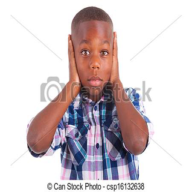

In [27]:
img_url = "https://i.ibb.co/yVLvm1R/b26d35d6ffe4.jpg"
img_request = requests.get(img_url, stream=True)
img = PIL.Image.open(io.BytesIO(img_request.content))
img_tensor = preprocess(img)
img_tensor = img_tensor.unsqueeze(0)
save_image(img_tensor[0], 'data/test_pics/pred_img.png')
open_image('data/test_pics/pred_img.png')

In [28]:
img_tensor.shape

torch.Size([1, 3, 192, 192])

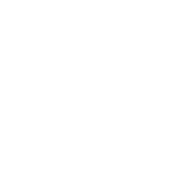

In [92]:
# pred_img = predict(img_tensor, model)

output_img = model(img_tensor).squeeze()
output_img.shape

save_image(output_img, 'data/test_pics/pred_img_gen.png')
open_image('data/test_pics/pred_img_gen.png')

In [135]:
pred_img = output_img.squeeze()
pred_img.shape

torch.Size([3, 192, 192])

In [136]:
# encoded_image = base64.b64encode(np.array(model(img_tensor).squeeze()))
encoded_image = base64.b64encode(np.array(pred_img).tobytes())
encoded_image[:500]

b'6Gd9PygThD9EaYE/4K9/P2AUgD8gGIA/cDeAP1QbgD9cdn8/GIJ/P8zYfz8QAYA/FAeAP5AKgD/0+38/CPt/PzT1fz8Y+H8/YOl/P7Dvfz/M2H8/INp/P7C8fz+gt38/TKp/P1Sifz+goH8/CJp/PwCZfz9Ijn8/qJF/P0CNfz9okn8/CI9/P7CQfz/ciX8/wIt/P7CBfz+og38/yH9/P6iIfz8Ih38/II5/P4iRfz+slX8/KJZ/P+iVfz+Mmn8/YJx/PxCjfz/IpX8/iKt/P/Sqfz/Qrn8/kLN/Pyi6fz84w38/ZMh/P5jYfz9A3n8/COl/P4Dsfz9ACoA/tA2AP1ALgD84B4A/+AeAP0AHgD9ECIA/QBaAP4QfgD9cE4A/4OZ/PxDMfz9YqH8/QJd/P+R+fz8oeX8/KEB/P+g7fz9we38/7HB/P7iFfz/ke38/+JF/PwRofz+4YX8/IBl/P6g7fz/oYX4/gKV+PxiLfj/o0X4/2BR/'

In [137]:
session = HTMLSession()
upload_form = {
    "image": encoded_image
}

r = session.post(f"https://api.imgbb.com/1/upload?key={IMGBB_KEY}", data=upload_form)

In [138]:
r.json()

{'status_code': 400,
 'error': {'message': "Can't get target upload source info",
  'code': 310,
  'context': 'CHV\\UploadException'},
 'status_txt': 'Bad Request'}

Use Imgbb Api and requests-html to upload images

In [156]:
session = HTMLSession()

In [163]:
image_path = "data/test_pics/test5.jpg"

with open(image_path, "rb") as image_file:
    encoded_image = base64.b64encode(image_file.read())
    
upload_form = {
    "image": encoded_image
}

In [164]:
r = session.post(f"https://api.imgbb.com/1/upload?key={IMGBB_KEY}", data=upload_form)

In [165]:
r.json()#["data"]["url"]

{'data': {'id': 'JQZ1NYT',
  'url_viewer': 'https://ibb.co/JQZ1NYT',
  'url': 'https://i.ibb.co/5FZ0dQ3/4f851a0d8082.jpg',
  'display_url': 'https://i.ibb.co/5FZ0dQ3/4f851a0d8082.jpg',
  'title': '4f851a0d8082',
  'time': '1572289988',
  'image': {'filename': '4f851a0d8082.jpg',
   'name': '4f851a0d8082',
   'mime': 'image/jpeg',
   'extension': 'jpg',
   'url': 'https://i.ibb.co/5FZ0dQ3/4f851a0d8082.jpg',
   'size': 20399},
  'thumb': {'filename': '4f851a0d8082.jpg',
   'name': '4f851a0d8082',
   'mime': 'image/jpeg',
   'extension': 'jpg',
   'url': 'https://i.ibb.co/JQZ1NYT/4f851a0d8082.jpg',
   'size': '11855'},
  'delete_url': 'https://ibb.co/JQZ1NYT/74eea857c1fd60bea909a655e39120bb'},
 'success': True,
 'status': 200}

In [5]:
json.dumps("AA")

'"AA"'

In [29]:
s3 = boto3.client("s3")

In [36]:
s3.get_object(Bucket="demarkify-models", Key="serialized_baseline_01.tar.gz")

{'ResponseMetadata': {'RequestId': '11DC3DF89B8CEA79',
  'HostId': 'evInqRO6WzUIdDqaLw+lkC2WFvzYwUslYOE0Ru7OiC7h95AMNp5fC/7V6SzjQxpvKYnsnIh+hNs=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'evInqRO6WzUIdDqaLw+lkC2WFvzYwUslYOE0Ru7OiC7h95AMNp5fC/7V6SzjQxpvKYnsnIh+hNs=',
   'x-amz-request-id': '11DC3DF89B8CEA79',
   'date': 'Fri, 08 Nov 2019 07:54:55 GMT',
   'last-modified': 'Mon, 28 Oct 2019 00:36:43 GMT',
   'etag': '"3085920fee38bc73cabd9d030fc8bd46-19"',
   'accept-ranges': 'bytes',
   'content-type': 'binary/octet-stream',
   'content-length': '153776130',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'AcceptRanges': 'bytes',
 'LastModified': datetime.datetime(2019, 10, 28, 0, 36, 43, tzinfo=tzutc()),
 'ContentLength': 153776130,
 'ETag': '"3085920fee38bc73cabd9d030fc8bd46-19"',
 'ContentType': 'binary/octet-stream',
 'Metadata': {},
 'Body': <botocore.response.StreamingBody at 0x7f3b8c4c1650>}